In [1]:
%load_ext autotime

In [2]:
import os
import pandas as pd
import numpy as np

from glob import glob
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.nddata import Cutout2D

from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import fftpack
from matplotlib.colors import LogNorm

from tqdm import tqdm

from piaa.utils import helpers
from pong.utils import storage

from IPython.display import display, Image

time: 1.57 s


In [3]:
rgb_masks = np.load('/var/panoptes/rgb_masks.npz')
r_mask = rgb_masks['r']
g_mask = rgb_masks['g']
c_mask = rgb_masks['c']
b_mask = rgb_masks['b']

time: 340 ms


In [4]:
camera_id = 'ee04d1'

time: 878 µs


## Make Master Flat

In [5]:
# Get our calibration images for the unit
calibration_images = storage.get_observation_blobs('PAN001/calibration/')
len(calibration_images)

482

time: 425 ms


In [6]:
# Save FITS files to this location
local_save_dir = '/var/panoptes/images/flats'
os.makedirs(local_save_dir, exist_ok=True)

time: 1.16 ms


In [7]:
# !!!WARNING - Download from the google storage buckets - lots of data - WARNING!!!
file_list = list()
for fn in tqdm(calibration_images):
    local_fn = storage.download_fits_file(fn, save_dir=local_save_dir, unpack=False)
    file_list.append(local_fn)

100%|██████████| 482/482 [00:00<00:00, 34498.05it/s]

time: 19 ms


In [8]:
# Get the local path names
flat_files = [fn for fn in file_list if 'flats_{}'.format(camera_id) in fn]
len(flat_files)

54

time: 4.25 ms


In [10]:
bias = 2047
min_level = 1000
saturation_level = 11000
desired_percentage = 0.5

time: 1.17 ms


In [11]:
desired_count = (saturation_level + min_level) * desired_percentage
print("Desired count: ", desired_count)

Desired count:  6000.0
time: 1.84 ms


In [12]:
center_position = (int(3476/2), int(5208/2))

time: 1.13 ms


In [13]:
r_region = Cutout2D(r_mask, center_position, 1000).data
g_region = Cutout2D(g_mask, center_position, 1000).data
c_region = Cutout2D(c_mask, center_position, 1000).data
b_region = Cutout2D(b_mask, center_position, 1000).data

time: 3.11 ms


In [14]:
enough_counts_fractional_error = 0.0125
fraction_saturated_pixels_limit = 0.05

time: 1.09 ms


In [15]:
def inv_median_center(data, stats_region=0.3, xaxis_number=1, yaxis_number=0):
    """
    Compute 1/median for scaling the flat field data using only a limited central region
    specified by stats_region parameter.
    """

    try:
        h = data.shape[0]
        w = data.shape[1]
    except IndexError:
        h = w = int(np.sqrt(data.shape[0]))
        data = data.reshape(h, w)
        
    center_xy = (int(h/2), int(w/2))
    size = (w*stats_region, h*stats_region)
    
    d0 = Cutout2D(data, center_xy, size)

    return 1. / np.median(d0.data)

time: 2.85 ms


In [16]:
flat_data = None

num_flats = 0

master_flat_data = list()
master_flat_weights = list()
flat_fn = list()
exp_times = list()

for f in flat_files:
    with fits.open(f) as hdul:
#         print()
        if f.endswith('.fits'):
            hdu = hdul[0]
        elif f.endswith('.fz'):
            hdu = hdul[1]

        exp_time = float(hdu.header['EXPTIME'])
        # Skip flats under 3 seconds (kind of empirical)
        if exp_time < 3:
            continue            
            
        # Get data and remove bias
        d0 = hdu.data - bias
        
        # Get center region
        c0 = Cutout2D(d0, center_position, 1000)
        
        mean, median, std = sigma_clipped_stats(c0.data)

        median_counts = np.median(c0.data)
        frac_saturated = np.sum(c0.data >= saturation_level) / (c0.data.shape[1] * c0.data.shape[0])

#         print("Median:   ", median_counts)
#         print("FEC        {:.02%}".format(np.sqrt(median_counts) / median_counts))
#         print("Saturated: {:.0%}".format(frac_saturated))
        
        # Figure out if within acceptables counts
        if (np.sqrt(median_counts) / median_counts < enough_counts_fractional_error 
            and frac_saturated < fraction_saturated_pixels_limit):
            
            flat_fn.append(f)
            exp_times.append(exp_time)

            print("Using Flat: {:5.02f}s μ={:.02f} σ={:.02f}".format(exp_time, mean, std))
            
            g_data = np.ma.array(d0, mask=np.logical_and(~g_mask, ~c_mask))
            master_flat_weights.append(inv_median_center(g_data))
            master_flat_data.append(d0)

Using Flat:  3.90s μ=6258.91 σ=2701.58


/home/wtylergee/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Using Flat:  4.90s μ=6350.23 σ=2747.46
Using Flat:  5.90s μ=6140.73 σ=2663.96
Using Flat:  9.90s μ=6867.11 σ=2989.15
Using Flat: 12.00s μ=6491.49 σ=2835.36
Using Flat: 15.00s μ=6357.96 σ=2785.29
Using Flat: 19.00s μ=6248.06 σ=2745.33
Using Flat: 25.00s μ=6307.65 σ=2779.78
Using Flat: 34.00s μ=6455.67 σ=2854.68
Using Flat: 46.00s μ=6453.70 σ=2864.34
time: 14.6 s


In [17]:
"Good flats: {}".format(len(master_flat_data))

'Good flats: 10'

time: 2.87 ms


In [18]:
flat_data_file = '/var/panoptes/images/pan001-{}-master_flat_data.npz'.format(camera_id)

time: 1.31 ms


In [19]:
# Save the file
np.savez_compressed(flat_data_file, *master_flat_data)

time: 39.3 s


In [20]:
ls -lh $flat_data_file

-rw-r--r-- 1 wtylergee wtylergee 279M Sep  5 10:37 /var/panoptes/images/pan001-ee04d1-master_flat_data.npz
time: 136 ms


In [6]:
# Or load the file
master_flat_npz = np.load(flat_data_file)

master_flat_data = [master_flat_npz[f].astype(np.float32) for f in master_flat_npz.files]

time: 8.74 s


### Save Master Flats FITS

#### Combine flats

In [21]:
# Combine all the flats
master_flat = np.median(master_flat_data, axis=0)
master_flat.shape

(3476, 5208)

time: 2.74 s


In [22]:
flat_fits = '/var/panoptes/images/pan001-{}-master-flat.fits'.format(camera_id)

time: 1.08 ms


In [23]:
hdu = fits.PrimaryHDU(master_flat.astype(np.float32))
hdul = fits.HDUList([hdu])
hdul.writeto(flat_fits, overwrite=True)

time: 161 ms


### Gain

Do a simple gain check.

In [ ]:
# Quick gain 
gains = list()
flat0 = sigma_clip(master_flat_data[0].astype(np.float), iters=2)

for d0 in tqdm(master_flat_data):
    flat1 = sigma_clip(d0.astype(np.float), iters=2)
    gain = (flat0 + flat1).mean() / (flat0 - flat1).std()**2
    gains.append(gain)

In [37]:
gains

array([       inf, 1.57818152, 1.53488695, 0.14351352, 0.47424207,
       0.72844737, 0.88179917, 0.54020877, 0.24770048, 0.19373572])

time: 4.1 ms


In [38]:
gains = np.array(gains[1:])
print("Gain is {:.02f} e-/ADU".format(gains.mean()))

Gain is 0.70 e-/ADU
time: 1.46 ms


In [45]:
np.array(master_flat_data).reshape(10, -1).sum(1)

array([107377300030, 108877868662, 105214448354, 117862413487,
       111483168779, 109270397995, 107577642205, 108845181234,
       111763613261, 112120875694], dtype=uint64)

time: 426 ms


### Examine Master Flat

In [19]:
# Load the master flat
master_flat = fits.getdata(
    '/var/panoptes/images/pan001-{}-master-flat.fits'.format(camera_id)) #.astype(np.float32)

time: 3.52 ms


In [25]:
r_data = np.ma.array(master_flat, mask=~r_mask)
g_data = np.ma.array(master_flat, mask=~g_mask)
c_data = np.ma.array(master_flat, mask=~c_mask)
b_data = np.ma.array(master_flat, mask=~b_mask)

time: 31.7 ms


Text(0.5,1,'Master flat pixel counts')

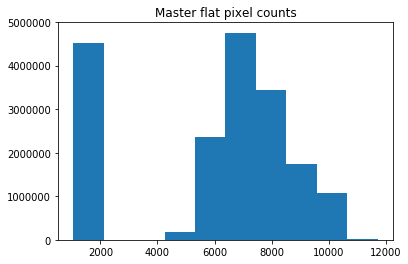

time: 608 ms


In [26]:
# Histogram of pixels
n, bins, patches = plt.hist(master_flat.flatten())
plt.title('Master flat pixel counts')

In [28]:
fig = Figure()
fft_fig = Figure()
FigureCanvas(fig)
FigureCanvas(fft_fig)

ax = fig.add_subplot(111)
ax2 = fft_fig.add_subplot(111)

# Show the flat
im = ax.imshow(master_flat, cmap='Greys', norm=LogNorm())
ax.set_title('Master Flat')

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# FFT
f0 = fftpack.fft2(master_flat)
ax2.imshow(np.abs(f0), cmap='Greys', norm=LogNorm(vmin=5))
ax2.set_title('Master Flat FFT')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

fig.tight_layout()
fig.set_size_inches(fig.get_size_inches() * 2)
fig.savefig('/var/panoptes/images/pan001-{}-master-flat-01.png'.format(camera_id), transparent=False)

fft_fig.tight_layout()
fft_fig.set_size_inches(fig.get_size_inches() * 2)
fft_fig.savefig('/var/panoptes/images/pan001-{}-master-flat-01-fft.png'.format(camera_id), transparent=False)

/home/wtylergee/miniconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


time: 6.48 s


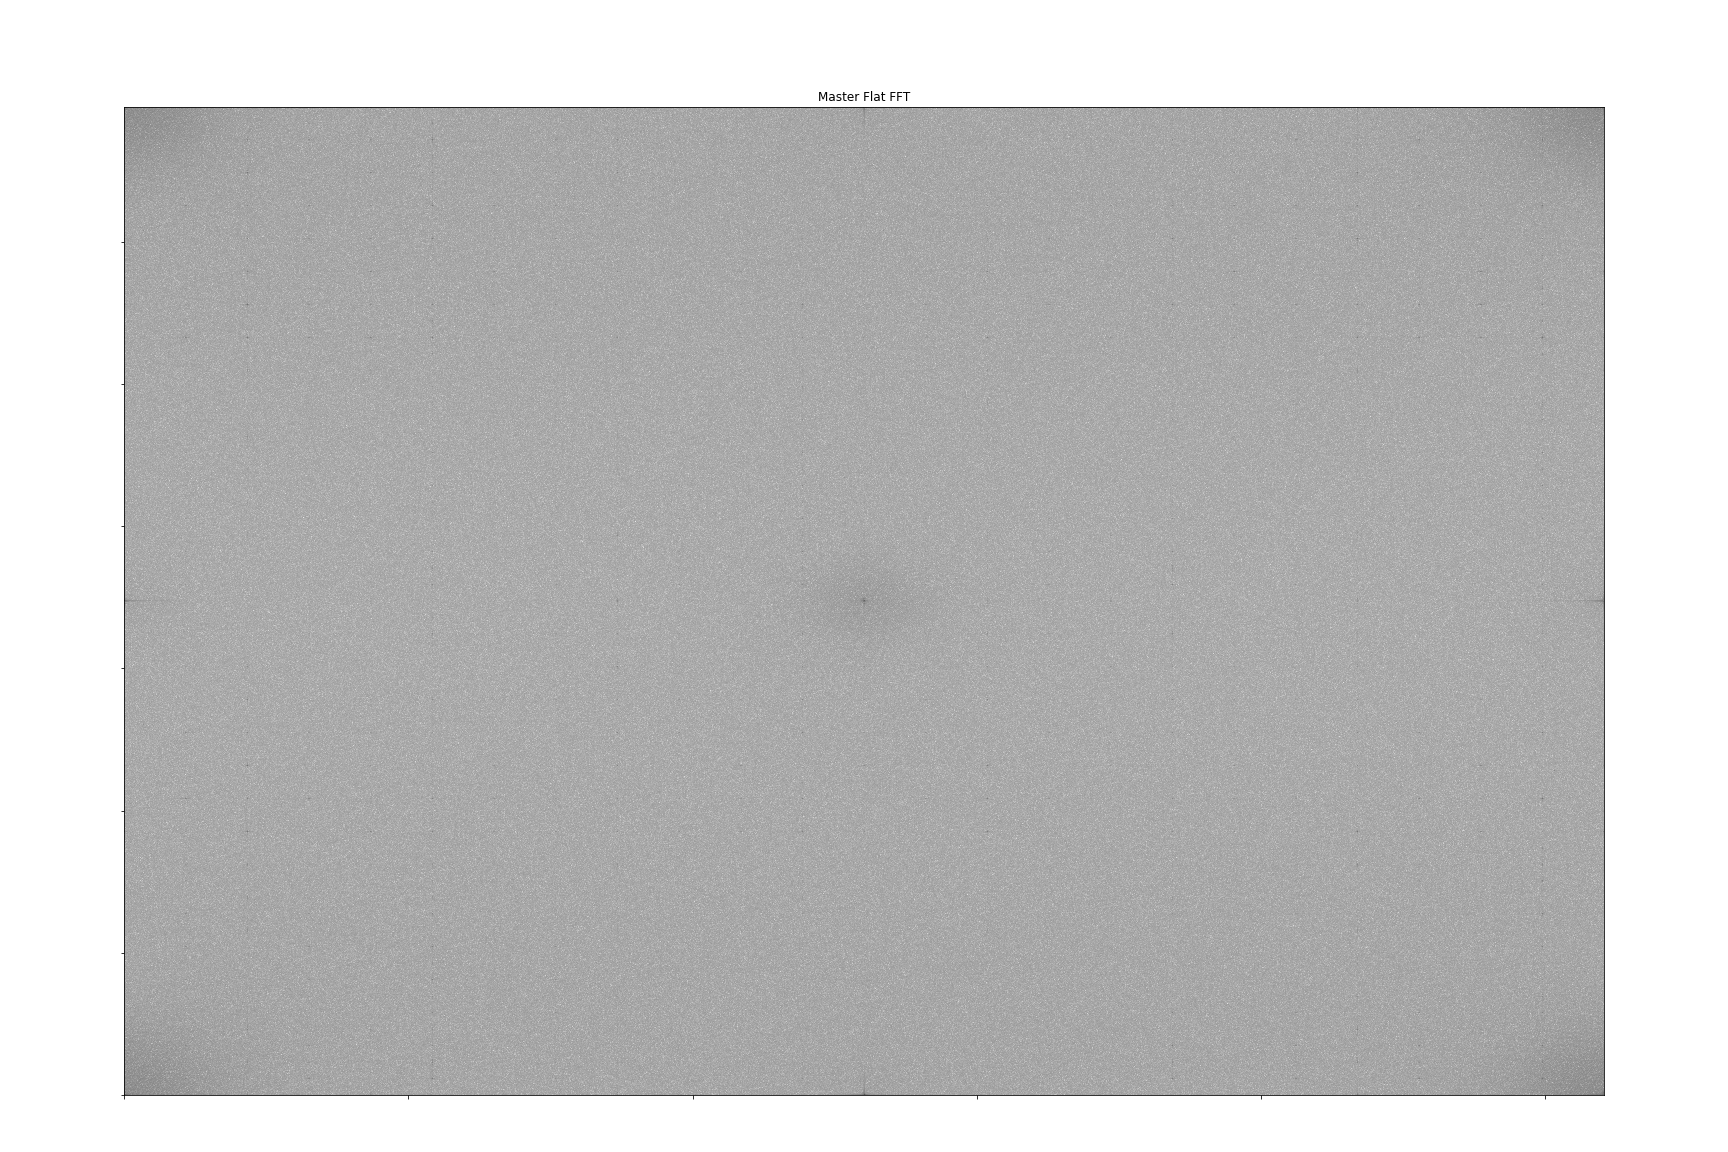

time: 28.6 ms


In [29]:
Image(filename='/var/panoptes/images/pan001-{}-master-flat-01-fft.png'.format(camera_id))

### Split color channels

In [33]:
for color, mask in zip(['Reds', 'Greens', 'Greens2', 'Blues'], [r_mask, g_mask, c_mask, b_mask]):
    fig = Figure()
    fft_fig = Figure()
    
    FigureCanvas(fig)
    FigureCanvas(fft_fig)
    
    ax = fig.add_subplot(111)
    ax2 = fft_fig.add_subplot(111)

    d0 = np.ma.array(master_flat, mask=~mask)

    width = int(5208/2)    
    height = int(3476/2)
    
    cm = color
    if color is 'Greens2':
        cm = 'Greens'
    
    d0 = d0.compressed().reshape(height, width)
        
    # Show the flat
    im = ax.imshow(d0, cmap=cm)
    ax.set_title('{} σ={:.2f}'.format(color, d0.std()))
    
    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    
    # Show the FFT
    f0 = fftpack.fft2(d0.astype(np.float))
    
    ax2.imshow(np.abs(f0), cmap='Greys', norm=LogNorm(vmin=5))
    ax2.set_title('{} FFT'.format(color))

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])    
    
    fig.tight_layout()
    fft_fig.tight_layout()
    
    fig.set_size_inches(fig.get_size_inches() * 2)
    fft_fig.set_size_inches(fft_fig.get_size_inches() * 2)
    
    fig.savefig(
        '/var/panoptes/images/pan001-{}-master-flat-channel-{}.png'.format(camera_id, color),
        transparent=False
    )
    fft_fig.savefig(
        '/var/panoptes/images/pan001-{}-master-flat-channel-{}-fft.png'.format(camera_id, color),
        transparent=False
    )

/home/wtylergee/miniconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


time: 8.19 s
